In [56]:
"""Lean Project Valuation Model - a three-stage cashflow model.

This simulates a payoff process with pivot/exercise decisions as well as
fixed development and operations costs.

Typical usage example:

  payoff = PayoffProcess(...)
  c1, c2 = CashflowProcess(...), CashflowProcess(...)
  project_value = LeanProjectValuation(payoff, c1, c2).npv()

"""

import numpy as np
from numpy.random import RandomState, Generator
from numpy.polynomial import Polynomial
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
from ipywidgets import interact, IntSlider
from itertools import zip_longest
from scipy.stats.distributions import lognorm, rv_frozen
from pathlib import Path

from typing import Dict, Tuple, Sequence


In [57]:
# Helper Functions
def d2sl(d):
    """Convert dictionary to a sorted list"""
    return [v for k, v in sorted(d.items())]

def pv_annuity(payment, r, t):
    """Present value of annuity, continuously compounded"""
    return payment * (1-np.exp(-r*t))/(np.exp(r)-1)


In [58]:
# Simulation Parameters
N = 25        # no simulations
T = 4        # simulation periods
STEP = 20     # timesteps per period
DRIFT = 0.02  # cashflow drift rate
VOL = 1.0     # cashflow volatility
START = 3.0   # initial cashflow rate c0

# Plotting constants
TIME_ARRAY = np.linspace(0, T, STEP*T+1)
FIGSIZE = (6,4)


In [59]:
class CashflowProcess:
    """Cashflow Process - Geometric Brownian Motion (with optional drift)"""

    def __init__(self, mu: float = 0.0, sigma: float = 1.0):
        """Initializes the cashflow processes based on drift and volatility parameters
        """
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, y: np.ndarray, rnd: np.random.RandomState = RandomState()) -> np.ndarray:
        """Simulates n cashflow processes from time array t and an intercept y
        """
        # verify input
        assert t.ndim == 1, "One dimensional time vector required"
        assert t.size > 0, "At least one time point is required"
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), "Increasing time vector required"
        assert y.reshape(-1, 1).shape[1] == 1, "Input y must be resizable to a column array"
        
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)

        # run simulation
        sim = (y.reshape(1,-1)-1) + np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T
        return sim

    def distribution(self, t: float) -> rv_frozen:
        """Return the distribution of the process
        """
        mu_t = (self.mu - self.sigma**2 / 2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)


class CostProcess(CashflowProcess):
    """Cost Process - constant cost process"""

    def __init__(self):
        """Initializes constant cost processes as cashflows without drift or volatility
        """
        super().__init__(0, 0)


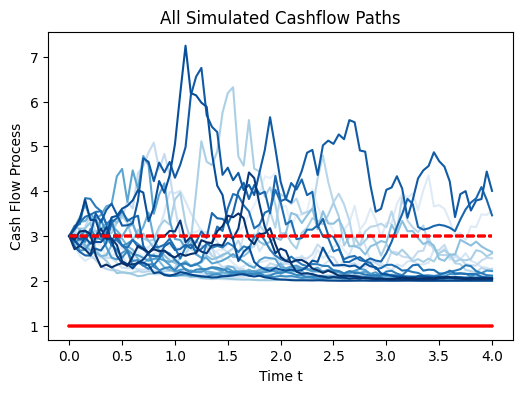

Payoff Process - trials: 25, drift: 0.02, vol: 1.0


In [60]:
# Cashflow Processes
po = CashflowProcess(mu=DRIFT, sigma=VOL)
cd = CostProcess()  # development 
co = CostProcess()  # operations

# Simulate
rnd = RandomState(seed=1230)
payoff = po.simulate(TIME_ARRAY, N, np.array([3.0]), rnd)
cost_dev = cd.simulate(TIME_ARRAY, N, np.array([1.0]), rnd)
cost_ops = co.simulate(TIME_ARRAY, N, np.array([3.0]), rnd)

assert payoff.shape == cost_dev.shape == cost_ops.shape, "All simulated cashflows must have the same shape"
assert payoff.all() > 0 and cost_dev.all() > 0 and cost_ops.all() >= 0, "All simulate cashflows must be non-negative"

# plot all cashflow and cost processes
plt.figure(figsize=FIGSIZE)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))

plt.plot(TIME_ARRAY, payoff)
plt.plot(TIME_ARRAY, cost_dev, color='red')
plt.plot(TIME_ARRAY, cost_ops, color='red', linestyle='dashed')

plt.title("All Simulated Cashflow Paths")
plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.show()

txt = f"""Payoff Process - trials: {N}, drift: {DRIFT}, vol: {VOL}"""
print(txt)

In [72]:
class LeanProjectValuation:
    """Lean project valuation"""

    def __init__(self, payoff: CashflowProcess, dev: CostProcess, ops: CostProcess, seed: int,
                 ivs: np.ndarray = np.array([3]),
                 thresholds: Dict = {},
                 n: int = 25):
        """Initializes the project with a set of cashflow process"""
        self.payoff = payoff
        self.cost_dev = dev
        self.cost_ops = ops
        self.threshold_map = thresholds
        self.nobs = n
        self.initial_vals = ivs
        self.seed = seed

        # exercise decisions
        self.exercise_decisions = {}

        # exercise time and value series
        self.completion_times, self.completion_vals = {}, {}
        self.abandon_times, self.abandon_vals = {}, {}
        self.pivot_times, self.pivot_vals = {}, {}

        # path results
        self.payoff_paths = {}
        self.cost_ops_paths = {}
        self.cost_dev_paths = {}

    def _generate_pivot_shocks(self, stage_values: np.ndarray, threshold: Tuple) -> np.ndarray:
        """Generates an array of shocks for a pivot stage given a threshold
        """
        rnd = RandomState(self.seed)
        cols = stage_values.shape[0]
        shocks = np.zeros(cols)
        # if a threshold band exists, form shocks
        if len(threshold) == 2:
            draws = rnd.uniform(0, 2, size=cols)
            mask = np.ma.masked_outside(stage_values, threshold[0], threshold[1])
            diff_mask = (mask * draws) - stage_values
            shocks = diff_mask.filled(0.0)
        return shocks
    
    def _generate_exercise(self, period, payoff_vals: np.ndarray, cost_ops_vals: np.ndarray):
        """Determine the exercise decision based on the path location and threshold"""
        # initialize decision, exercise values, and continuation value arrays
        decision_vals = np.zeros(payoff_vals.shape).astype(int)
        continuation_vals = payoff_vals.copy()

        # build any thresholds and update exercises
        self.pivot_shocks = np.zeros(self.nobs)
        lower_bound = upper_bound = cost_ops_vals
        if period in self.threshold_map.keys() and len(self.threshold_map[period]) == 2:
            # then a threshold exists and we should build an upper and lower bound
            lb, ub = self.threshold_map[period]
            lower_bound = lb * cost_ops_vals
            upper_bound = ub * cost_ops_vals
        
        # continuation decisions
        continuation_vals[payoff_vals <= lower_bound] = 0 
        # update decisions with abandons and completions
        decision_vals[payoff_vals <= lower_bound] = -1
        decision_vals[payoff_vals > upper_bound] = 1
        
        return [(dec,val,cont) for dec,val,cont in zip(decision_vals,payoff_vals,continuation_vals)]

    def generate_paths(self, t: np.ndarray, periods: int) -> np.ndarray:
        """Generates paths with all exercises
        """
        # initialize pivots with a zero shock array
        pivot_shocks = np.zeros(self.nobs)
        
        arrays = []
        init_vals = self.initial_vals
        idx_now = np.where(t == 0)[0][0]
        idx_next = np.where(t == 1)[0][0]
        for i in range(periods):
            # use a new determined seed for each period
            rnd = RandomState(self.seed+i)
            
            # simulate over the sub interval
            time_interval = t[idx_now:idx_next+1]
            payoff_sim = self.payoff.simulate(time_interval, self.nobs, init_vals, rnd)
            cost_ops_sim = self.cost_ops.simulate(time_interval, self.nobs, self.initial_vals)

            # store initial values for next stage for use in pivot evaluation
            init_vals = payoff_sim[-1,:]
            init_cost_vals = cost_ops_sim[-1,:]
            if i < periods-1:
                arrays.append(payoff_sim[:-1,:])
            else:
                arrays.append(payoff_sim)

            # apply any shocks for this period, we'll be using these to begin the next simulation
            init_vals += pivot_shocks

            # exercise function to assess each paths future depending on these post-shock end values
            ex_decisions = self._generate_exercise(i, init_vals, init_cost_vals)
            self.exercise_decisions[i] = ex_decisions

            # check if pivot threshold exists for this period, queue up pivots
            if (i+1) in self.threshold_map.keys():
                threshold = self.threshold_map[i+1]
                # generate and store pivot shocks
                pivot_shocks = self._generate_pivot_shocks(init_vals, threshold)
                self.pivot_vals[i+1] = pivot_shocks
            else:
                pivot_shocks = np.zeros(self.nobs)
        
        # stack the interval arrays
        return np.vstack(arrays)

    # def generate_optimal_paths(self, periods, paths)
    #     """Generate paths with first exercise and appropriate continuation values"""
    #     # iterate backward through periods, setting continuation values according to exercise
    #     for p in periods:
    #         exercise, ex_val, payoffs = self.exercise_decisions[p][0]


    # def valuation(self) -> float:
    #     """NPV all cost and cashflow paths together"""
    #     # generate paths if they don't exist
    #     if len(self.paths) == 0: self.exercise_paths()

    #     # npv each path and add to array
    #     path_valuation = []
    #     for ex_type, ex_idx, ex_time, ex_val, path in self.paths.values():
    #         # calculate development cost, ends at exercise
    #         dev_cost = pv_annuity(self.cost_dev[0], DRIFT, ex_time)
    #         pv_dev = dev_cost

    #         # calculate ops cost, starts at exercise
    #         ops_cost = pv_annuity(self.cost_ops[0], DRIFT, 3)
    #         pv_ops = ops_cost * np.exp(-DRIFT * ex_time)

    #         # calculate return
    #         ret = pv_annuity(ex_val, DRIFT, 3)
    #         pv_ret = ret * np.exp(-DRIFT * ex_time)

    #         # calculate path npv
    #         path_npv = pv_ret - pv_dev - pv_ops
    #         path_valuation.append(path_npv)
        
    #     # return the mean of those paths
    #     return np.mean(path_valuation)


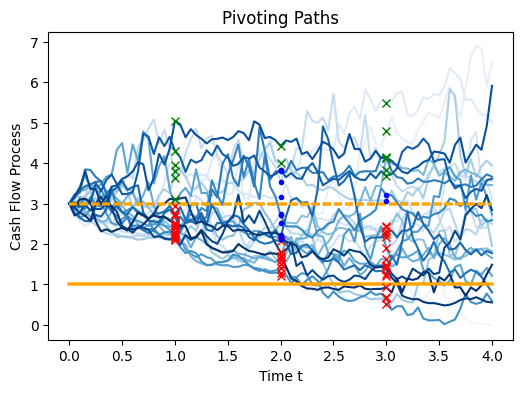

Payoff Process - trials: 25, drift: 0.02, vol: 1.0


In [73]:
# Create a project instance and get the valuation
initials = np.array([3])
threshold_dict = {1:(0.7,1.3),2:(0.9,1.1)}
seed = 1230

lpv = LeanProjectValuation(po, cd, co, seed, initials, threshold_dict)
paths = lpv.generate_paths(TIME_ARRAY, T)

# plot all cashflow and cost processes
plt.figure(figsize=FIGSIZE)
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))

plt.plot(TIME_ARRAY, paths)
plt.plot(TIME_ARRAY, cost_dev, color='orange', )
plt.plot(TIME_ARRAY, cost_ops, color='orange', linestyle='dashed')

for stage in [1,2,3]:
    abandons = [v for ex,v,_ in lpv.exercise_decisions[stage-1] if ex == -1]
    plt.plot(np.repeat([stage],len(abandons)), abandons, "rx")
    completions = [v for ex,v,_ in lpv.exercise_decisions[stage-1] if ex == 1]
    plt.plot(np.repeat([stage],len(completions)), completions, "gx")
    pivots = [v for ex,v,_ in lpv.exercise_decisions[stage-1] if ex == 0]
    plt.plot(np.repeat([stage],len(pivots)), pivots, "b.")

plt.title("Pivoting Paths")
plt.xlabel("Time t")
plt.ylabel("Cash Flow Process")
plt.show()

txt = f"""Payoff Process - trials: {N}, drift: {DRIFT}, vol: {VOL}"""
print(txt)

In [75]:
ex = lpv.exercise_decisions 
ex[0]

[(-1, 2.296060055852501, 0.0),
 (-1, 2.094125162170435, 0.0),
 (-1, 2.431275394182599, 0.0),
 (-1, 2.7400941163224846, 0.0),
 (1, 3.954406552486512, 3.954406552486512),
 (-1, 2.1856836669192607, 0.0),
 (1, 3.6362354188079453, 3.6362354188079453),
 (-1, 2.2857966903644305, 0.0),
 (1, 3.817154129697551, 3.817154129697551),
 (-1, 2.116918352639553, 0.0),
 (-1, 2.40102583896771, 0.0),
 (-1, 2.2138769105639393, 0.0),
 (-1, 2.4636722990449296, 0.0),
 (-1, 2.9328535257276744, 0.0),
 (-1, 2.209021633354914, 0.0),
 (-1, 2.112038713538085, 0.0),
 (-1, 2.240947483253822, 0.0),
 (-1, 2.4721212643545885, 0.0),
 (-1, 2.7424344240966807, 0.0),
 (-1, 2.6865110013526583, 0.0),
 (1, 4.300244575953919, 4.300244575953919),
 (1, 5.0510366948497225, 5.0510366948497225),
 (-1, 2.144112984535477, 0.0),
 (1, 3.1016718679282564, 3.1016718679282564),
 (-1, 2.5231580265346807, 0.0)]

In [64]:
# # Plot all exercises and continuation
# grey, green = "#dddddd", "#afe1af"
# plt.figure(figsize=FIGSIZE)
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N))))

# plt.plot(TIME_ARRAY, lpv.cashflow)
# plt.plot(d2sl(lpv.completion_times), d2sl(lpv.completion_vals), "bd")
# plt.plot(d2sl(lpv.abandon_times), d2sl(lpv.abandon_vals), "rx")
# plt.plot(d2sl(lpv.success_times), d2sl(lpv.success_vals), "go", markerfacecolor='none')
# plt.plot(d2sl(lpv.failure_times), d2sl(lpv.failure_vals), "ro", markerfacecolor='none')
# plt.plot(d2sl(lpv.continue_times), d2sl(lpv.continue_vals), "o", color="grey", markerfacecolor='none')

# plt.title("All Simulated Paths and Possible Exercises")
# plt.legend(["Simulated Paths"])
# plt.xlabel("Time")
# plt.ylabel("Cash Flow Process")

# plt.show()


In [65]:
# # Formatting for decision types
# FORMATS = {
#     0: ("--", "grey", "d", "blue", ":", "blue"),  # completion
#     1: ("--", "grey", "x", "red", "--", "grey"),    # abandon
#     2: ("--", "grey", "o", "green", ":", "green"), # success
#     3: ("--", "grey", "x", "red", "--", "grey"),    # failure
# }

# # Plot exercise and continuation
# grey = "#dddddd"
# plt.figure(figsize=FIGSIZE)
# plt.gca().set_prop_cycle(
#     plt.cycler('color', plt.cm.Blues(np.linspace(0, 1, N)))
# )

# # given ex_id, cf, ex_line, ex_color, pre_ex_line, pre_ex_color, post_ex_line, post_ex_color, 
# n_timesteps, n_paths = cashflow.shape
# for ex_type, ex_idx, ex_time, ex_val, path in lpv.paths.values():
#     # create a new time array depending on the length of the path
#     nobs = path.shape[0]-1
#     t = np.linspace(0, nobs/STEP, nobs+1)
#     # active paths
#     (handle_path,) = plt.plot(
#         t[0 : ex_idx+1],
#         path[0 : ex_idx+1],
#     )
#     # stopped paths
#     (handle_stopped_path,) = plt.plot(
#         t[ex_idx :],
#         path[ex_idx :],
#         FORMATS[ex_type][4],
#         color=FORMATS[ex_type][5] 
#     )
#     # exercise point
#     (handle_first_ex,) = plt.plot(
#         ex_time, ex_val,
#         FORMATS[ex_type][2],
#         color=FORMATS[ex_type][3]
#     )

# plt.legend(
#     [handle_path, handle_stopped_path],
#     ["Path before exercise", "Path after exercise"],
# )
# plt.title("All Simulated Paths with Early Exercise")
# plt.xlabel("Time t")
# plt.ylabel("Cash Flow Process")
# plt.show()


# Valuation
To calculate the valuation of the project
- We note that the cost of each path is an annuity until completion. That is, we can calculate the present value of an annuity with a coupon of the development cost rate (continuous compounding).
- For successful paths we add to that the cost of operations as well as the three-period cashflow annuity from the project.


In [66]:
# valuation = lpv.valuation()
# print(f"Value of the project is: ${valuation}")


# Sensitivity Analysis
Now we vary our parameters, calculate new cashflows, and generate valuations.
- r (drift)
- sigma (volatility)


In [67]:
# # Default Simulation Parameters
# N = 25        # no simulations
# T = 3         # simulation periods
# STEP = 20     # timesteps per period
# DRIFT = 0.02  # cashflow drift rate
# VOL = 1.0     # cashflow volatility
# START = 3.0   # initial cashflow rate c0

In [68]:
# # Simulate r
# N = 1000
# STEP = 100
# TIME_ARRAY = np.linspace(0, T, STEP*T+1)

# r_range = np.arange(-0.2, 0.2, 0.01)
# rnd = RandomState(seed=1234)
# r_cfs = [CashflowProcess(mu=r, sigma=VOL).simulate(TIME_ARRAY, N, STEP, rnd) for r in r_range]
# r_cds = [CostProcess(1).generate(TIME_ARRAY) for r in r_range]
# r_cos = [CostProcess(0.5).generate(TIME_ARRAY)  for r in r_range]
# # Valuation
# r_vals = [LeanProjectValuation(cp[0], cd, co).valuation() for cp, cd, co in zip(r_cfs, r_cds, r_cos)]

# # Plot results
# plt.title("Sensitivity Analysis: r (cashflow drift rate)")
# plt.xlabel("r")
# plt.ylabel("Project Value")
# plt.scatter(r_range, r_vals)
# plt.show()

In [69]:
# # Simulate volatility
# N = 1000
# STEP = 100
# TIME_ARRAY = np.linspace(0, T, STEP*T+1)

# sigma_range = np.arange(0, 5, 0.1)
# rnd = RandomState(seed=1234)
# rnd = RandomState()
# sigma_cfs = [CashflowProcess(mu=DRIFT, sigma=s).simulate(TIME_ARRAY, N, STEP, rnd) for s in sigma_range]
# sigma_cds = [CostProcess(1).generate(TIME_ARRAY) for s in sigma_range]
# sigma_cos = [CostProcess(0.5).generate(TIME_ARRAY)  for s in sigma_range]
# # Valuation
# sigma_vals = [LeanProjectValuation(cp[0], cd, co).valuation() for cp, cd, co in zip(sigma_cfs, sigma_cds, sigma_cos)]

# # Plot results
# plt.title("Sensitivity Analysis: Sigma (cashflow volatility)")
# plt.xlabel("Sigma")
# plt.ylabel("Project Value")
# plt.scatter(sigma_range, sigma_vals)
# plt.show()